# Sustainability Analysis of Commercial Building Energy Consumption in the United States

### By: Muhammad Umair Qureshi (30214382), Osama Bilgrami (30213085), and Annie Shamirian (30223202)

This project aims to leverage machine learning methodologies to uncover the underlying factors influencing energy consumption in commercial buildings across the United States. Our primary objective is to predict total energy usage based on a range of building characteristics. By doing so, we seek to identify key attributes of commercial buildings that merit particular attention, with the ultimate goal of fostering sustainability and energy efficiency.

The dataset utilized in this project is the 2018 Commercial Buildings Energy Consumption Survey (CBECS) Data, sourced from the U.S. Energy Information Administration. This publicly available dataset encompasses information on diverse building features and energy consumption metrics across 50 U.S. states and the District of Columbia. With a sample size of 6,436 buildings and approximately 1200 features, the dataset offers comprehensive insights into various aspects of commercial buildings, including size, occupancy, construction materials, equipment, and energy usage patterns. The target variable for our analysis is total energy consumption.

#### Guiding Questions:
1. Which features are the most important in determining total energy consumption?

2. What is the magnitude of influence each important feature has on total energy consumption?

To answer the above questions, we plan to employ the following models in our report: Logistic Regression, Decision Tree, Random Forest, LightGBM, Naive Bayes, Quadratic Discriminant Analysis (QDA), and Support Vector Machine (SVM).

We will summarize the key evaluation metrics for each model and compare. The best performing models will be used to derive feature importance from to address our first guiding question and to determine the magnitude of the effects to answer our second guiding question.

In [1]:
# Importing all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import shap
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB as NB
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv("building+consumption.csv")
df

,PUBID,REGION,CENDIV,PBA,PUBCLIM,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,ZMFBTU,ZMFEXP,ZELCNS,ZELEXP,ZNGCNS,ZNGEXP,ZFKCNS,ZFKEXP,ZDHBTU,ZDHEXP
0,1,3,5,2,3,210000,8,1,4,2,...,0,0,0,0,9,9,1,1,0,0
1,2,4,9,2,4,28000,5,1,6,1,...,0,0,0,0,0,0,9,9,9,9
2,3,3,5,8,4,2100,2,1,4,2,...,0,0,0,0,9,9,9,9,9,9
3,4,3,7,5,5,240000,8,2,6,1,...,0,0,0,0,1,1,9,9,9,9
4,5,1,2,5,3,295000,8,3,6,2,...,0,0,0,0,0,0,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6431,6432,4,8,14,2,130000,7,1,1,2,...,0,0,0,0,0,0,9,9,9,9
6432,6433,3,7,1,4,1050,2,1,5,2,...,9,9,9,9,9,9,9,9,9,9
6433,6434,3,5,2,4,122000,7,2,6,1,...,1,1,1,1,9,9,9,9,9,9
6434,6435,3,5,23,4,15000,4,3,5,1,...,2,2,2,2,2,2,9,9,9,9


## Data Preprocessing

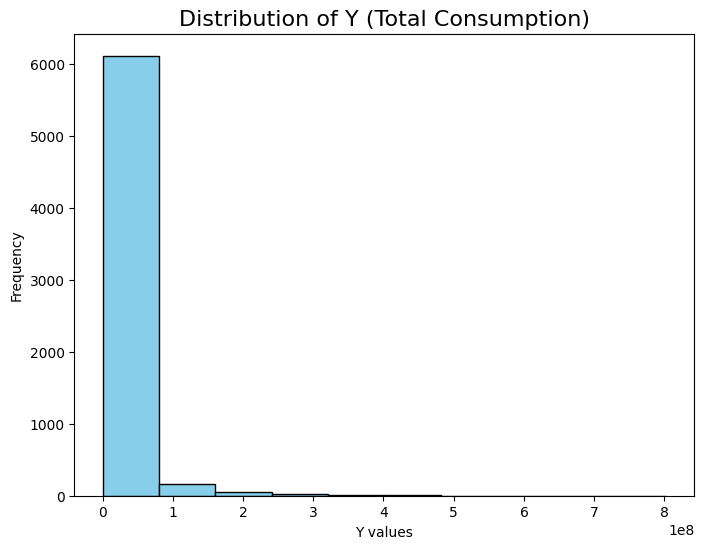

In [3]:
plt.figure(figsize=(8, 6))
plt.hist(df['Y'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Y (Total Consumption)', fontsize=16)
plt.xlabel('Y values')
plt.ylabel('Frequency')
plt.show()

To prepare the data for classification problems, we will split the y column (total consumption) by the median. This will divide buildings into having high and low total energy consumption. The median is used due to outliers and skewed distribution pictured above.

In [4]:
# drop every column starting with 'Z' ('imputation flag' columns)
df.drop(columns=[col for col in df.columns if col.startswith('Z')], inplace=True)

# drop every column starting with 'MF' (unnecessary energy consumption variables)
df.drop(columns=[col for col in df.columns if col.startswith('MF')], inplace=True)

# drop every column starting with 'FINAL' ('weight' columns)
df.drop(columns=[col for col in df.columns if col.startswith('FINAL')], inplace=True)

df.dropna(subset=['Y'], inplace=True)

# drop all columns with nulls
df.dropna(axis=1, how='any', inplace=True)

In [5]:
df

,PUBID,REGION,CENDIV,PBA,PUBCLIM,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,ELHTBTU,ELCLBTU,ELVNBTU,ELWTBTU,ELLTBTU,ELCKBTU,ELRFBTU,ELOFBTU,ELPCBTU,ELOTBTU
0,1,3,5,2,3,210000,8,1,4,2,...,0.0,1823745.0,8436752.0,0.0,1623736.0,0.0,305105.0,676685.0,995161.0,4847786.0
1,2,4,9,2,4,28000,5,1,6,1,...,2676.0,43482.0,566658.0,0.0,167247.0,0.0,226868.0,93334.0,55708.0,372694.0
2,3,3,5,8,4,2100,2,1,4,2,...,11021.0,2161.0,2199.0,799.0,17750.0,0.0,2429.0,2848.0,3651.0,9529.0
3,4,3,7,5,5,240000,8,2,6,1,...,14998.0,270861.0,174744.0,0.0,1151578.0,0.0,11998.0,3953.0,24723.0,321400.0
4,5,1,2,5,3,295000,8,3,6,2,...,0.0,0.0,40185.0,1125.0,683259.0,0.0,3224.0,854.0,2890.0,559027.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,6431,1,1,18,3,132000,7,1,5,1,...,0.0,202903.0,1877551.0,0.0,263384.0,0.0,306116.0,31809.0,375627.0,709453.0
6431,6432,4,8,14,2,130000,7,1,1,2,...,0.0,181607.0,710774.0,0.0,617647.0,185664.0,134955.0,56381.0,57876.0,407933.0
6433,6434,3,5,2,4,122000,7,2,6,1,...,931126.0,1142322.0,4461992.0,95318.0,1700051.0,0.0,11532.0,0.0,1700250.0,1711887.0
6434,6435,3,5,23,4,15000,4,3,5,1,...,102986.0,214333.0,143434.0,61879.0,153374.0,0.0,77970.0,17413.0,15947.0,173206.0


In [6]:
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
             PUBID       REGION       CENDIV          PBA      PUBCLIM  \
count  6357.000000  6357.000000  6357.000000  6357.000000  6357.000000   
mean   3222.335693     2.627025     5.098631    12.618531     3.652509   
std    1856.354968     1.007420     2.440647    11.802936     1.705754   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%    1616.000000     2.000000     3.000000     5.000000     2.000000   
50%    3224.000000     3.000000     5.000000    13.000000     3.000000   
75%    4828.000000     3.000000     7.000000    16.000000     5.000000   
max    6436.000000     4.000000     9.000000    91.000000     7.000000   

               SQFT        SQFTC        WLCNS        RFCNS       RFCOOL  ...  \
count  6.357000e+03  6357.000000  6357.000000  6357.000000  6357.000000  ...   
mean   1.709942e+05     5.646059     2.362907     4.349851     1.499292  ...   
std    2.863175e+05     2.292133     1.732858     2.089032     0.500039  

In [7]:
# check categorical columns
num_categorical = df.select_dtypes(include=['object']).shape[1]
print(f'There are {num_categorical} categorical columns in the DataFrame.')

There are 0 categorical columns in the DataFrame.


In [8]:
median_Y = df['Y'].median()
print(f'The median value of Y is {median_Y}.')

The median value of Y is 4207386.0.


In [9]:
df['Y_Class'] = df['Y'].apply(lambda x: 1 if x > 4207386 else 0)

df = df.drop('Y', axis=1)
df = df.drop('PUBID', axis=1)
df = df.drop('CDD65', axis=1)


In [10]:
df

,REGION,CENDIV,PBA,PUBCLIM,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,RFTILT,...,ELCLBTU,ELVNBTU,ELWTBTU,ELLTBTU,ELCKBTU,ELRFBTU,ELOFBTU,ELPCBTU,ELOTBTU,Y_Class
0,3,5,2,3,210000,8,1,4,2,1,...,1823745.0,8436752.0,0.0,1623736.0,0.0,305105.0,676685.0,995161.0,4847786.0,1
1,4,9,2,4,28000,5,1,6,1,1,...,43482.0,566658.0,0.0,167247.0,0.0,226868.0,93334.0,55708.0,372694.0,0
2,3,5,8,4,2100,2,1,4,2,3,...,2161.0,2199.0,799.0,17750.0,0.0,2429.0,2848.0,3651.0,9529.0,0
3,3,7,5,5,240000,8,2,6,1,1,...,270861.0,174744.0,0.0,1151578.0,0.0,11998.0,3953.0,24723.0,321400.0,0
4,1,2,5,3,295000,8,3,6,2,1,...,0.0,40185.0,1125.0,683259.0,0.0,3224.0,854.0,2890.0,559027.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,1,1,18,3,132000,7,1,5,1,3,...,202903.0,1877551.0,0.0,263384.0,0.0,306116.0,31809.0,375627.0,709453.0,1
6431,4,8,14,2,130000,7,1,1,2,1,...,181607.0,710774.0,0.0,617647.0,185664.0,134955.0,56381.0,57876.0,407933.0,1
6433,3,5,2,4,122000,7,2,6,1,1,...,1142322.0,4461992.0,95318.0,1700051.0,0.0,11532.0,0.0,1700250.0,1711887.0,1
6434,3,5,23,4,15000,4,3,5,1,2,...,214333.0,143434.0,61879.0,153374.0,0.0,77970.0,17413.0,15947.0,173206.0,0


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
X = df.drop("Y_Class", axis = 1)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


     feature        VIF
0     REGION  11.901913
1     CENDIV  12.140849
2        PBA   2.564057
3    PUBCLIM   2.502914
4       SQFT   5.014827
..       ...        ...
143  ELCKBTU        inf
144  ELRFBTU        inf
145  ELOFBTU        inf
146  ELPCBTU        inf
147  ELOTBTU        inf

[148 rows x 2 columns]


In [12]:
# filter out features with VIF greater than 5
high_vif_features = vif_data[vif_data['VIF'] > 5]

print(high_vif_features)

     feature        VIF
0     REGION  11.901913
1     CENDIV  12.140849
4       SQFT   5.014827
20      NOCC  67.311877
21    NOCCAT  67.110442
..       ...        ...
143  ELCKBTU        inf
144  ELRFBTU        inf
145  ELOFBTU        inf
146  ELPCBTU        inf
147  ELOTBTU        inf

[79 rows x 2 columns]


In [13]:
# Get the names of high VIF features
high_vif_feature_names = high_vif_features['feature'].tolist()

# Drop high VIF features from X
X_filtered = X.drop(high_vif_feature_names, axis=1)

# Combine X_filtered with "Y_Class" column from df
df0 = pd.concat([X_filtered, df["Y_Class"]], axis=1)

In [14]:
# new df with high VIF features removed
df0

,PBA,PUBCLIM,SQFTC,WLCNS,RFCNS,RFCOOL,RFTILT,BLDSHP,GLSSPC,NFLOOR,...,CWOTH,WOOTH,SOOTH,OTOTH,RFGEQP,LTEXPC,PKLT,WINTYP,HDD65,Y_Class
0,2,3,8,1,4,2,1,6,3,994,...,2,2,2,2,1.0,2.0,1.0,2,4463,1
1,2,4,5,1,6,1,1,11,3,5,...,2,2,2,2,1.0,1.0,1.0,1,2424,0
2,8,4,2,1,4,2,3,2,3,1,...,2,2,2,2,1.0,4.0,1.0,2,3218,0
3,5,5,8,2,6,1,1,2,2,1,...,2,2,2,2,1.0,2.0,1.0,2,1045,0
4,5,3,8,3,6,2,1,1,1,1,...,2,2,2,2,1.0,4.0,1.0,2,5076,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,18,3,7,1,5,1,3,6,3,5,...,2,2,2,2,1.0,1.0,1.0,3,6642,1
6431,14,2,7,1,1,2,1,2,3,3,...,2,2,2,2,1.0,3.0,1.0,2,5645,1
6433,2,4,7,2,6,1,1,11,5,5,...,2,2,2,2,1.0,3.0,1.0,2,2984,1
6434,23,4,4,3,5,1,2,2,4,1,...,2,2,2,2,1.0,2.0,1.0,3,2414,0


In [15]:
cols1 = ['PBA', 'PUBCLIM', 'WLCNS', 'RFCNS', 'RFTILT', 'BLDSHP', 'PBAPLUS', 'OWNTYPE']
df2 = df0[cols1].copy()

In [16]:
df2 = pd.get_dummies(df2.astype(str))
df2

,PBA_1,PBA_11,PBA_12,PBA_13,PBA_14,PBA_15,PBA_16,PBA_17,PBA_18,PBA_2,...,OWNTYPE_10,OWNTYPE_2,OWNTYPE_3,OWNTYPE_4,OWNTYPE_5,OWNTYPE_6,OWNTYPE_7,OWNTYPE_8,OWNTYPE_9,OWNTYPE_97
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
6431,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
6433,False,False,False,False,False,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False
6434,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [17]:
df0 = df0.drop(columns=cols1)

In [18]:
df0.reset_index(inplace=True)
df2.reset_index(inplace=True)
df1 = pd.merge(df0, df2, on='index')

In [19]:
df1 = df1.drop('index', axis=1)
df1

,SQFTC,RFCOOL,GLSSPC,NFLOOR,FLCEILHT,ATTIC,YRCONC,FACIL,GOVOWN,OWNOPR,...,OWNTYPE_10,OWNTYPE_2,OWNTYPE_3,OWNTYPE_4,OWNTYPE_5,OWNTYPE_6,OWNTYPE_7,OWNTYPE_8,OWNTYPE_9,OWNTYPE_97
0,8,2,3,994,12,2,2,2,1,1,...,False,False,False,False,False,False,False,True,False,False
1,5,1,3,5,8,2,6,1,2,1,...,False,True,False,False,False,False,False,False,False,False
2,2,2,3,1,9,1,6,2,2,1,...,False,False,True,False,False,False,False,False,False,False
3,8,1,2,1,25,2,9,2,2,1,...,False,False,False,False,False,False,False,False,False,False
4,8,2,1,1,30,2,4,2,2,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6352,7,1,3,5,10,1,8,1,1,1,...,False,False,False,False,False,False,False,False,True,False
6353,7,2,3,3,8,2,4,2,1,1,...,False,False,False,False,False,False,False,False,True,False
6354,7,1,5,5,14,2,6,2,2,2,...,False,True,False,False,False,False,False,False,False,False
6355,4,1,4,1,9,2,5,2,2,1,...,False,False,True,False,False,False,False,False,False,False


## Predictive Modelling

In [20]:
X = df1.drop(['Y_Class'], axis = 1).values
y = df1['Y_Class'].values

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
df1.dtypes

SQFTC         int64
RFCOOL        int64
GLSSPC        int64
NFLOOR        int64
FLCEILHT      int64
              ...  
OWNTYPE_6      bool
OWNTYPE_7      bool
OWNTYPE_8      bool
OWNTYPE_9      bool
OWNTYPE_97     bool
Length: 180, dtype: object

## Decision Tree

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree pipeline
dt_pipeline = Pipeline([
    ('transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler()),
    ('DT', DecisionTreeClassifier(random_state=42))
])

# parameter grid for Decision Tree
dt_param_grid = {
    'DT__max_depth': [None, 10, 20, 30]  # max depth of the tree
}

# hyperparameter tuning for Decision Tree
dt_grid_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='accuracy')
dt_grid_search.fit(X_train, y_train)
dt_best_model = dt_grid_search.best_estimator_

# predictions
dt_y_pred = dt_best_model.predict(X_test)

# calculating accuracy for Decision Tree
dt_accuracy = accuracy_score(y_test, dt_y_pred)
print("Decision Tree Classification Accuracy:", dt_accuracy)

# classification report for Decision Tree
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, dt_y_pred))

Decision Tree Classification Accuracy: 0.8985849056603774

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       660
           1       0.89      0.90      0.89       612

    accuracy                           0.90      1272
   macro avg       0.90      0.90      0.90      1272
weighted avg       0.90      0.90      0.90      1272



In [24]:
# Get the best hyperparameters
best_params = dt_grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'DT__max_depth': 10}


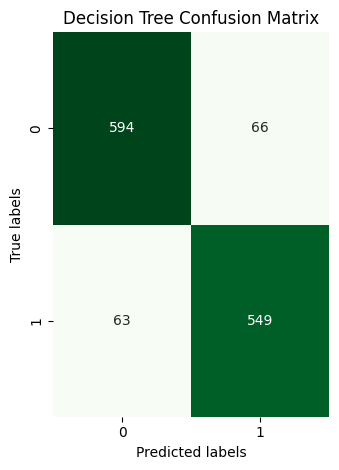

In [25]:
# confusion matrix for Decision Tree
dt_conf_matrix = confusion_matrix(y_test, dt_y_pred)

# plotting confusion matrix for Decision Tree
plt.subplot(1, 2, 2)
sns.heatmap(dt_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Decision Tree Confusion Matrix')

plt.tight_layout()
plt.show()

We opted for a Decision Tree model due to its interpretability, ease of implementation, and ability to handle both numerical and categorical data without requiring extensive preprocessing. Decision Trees are particularly useful for exploring the underlying structure of the data and identifying important features. Additionally, they can capture non-linear relationships between features and the target variable, which might be present in complex datasets like energy consumption scores.

After hyperparameter tuning via grid search, the selected Decision Tree model achieved a classification accuracy of approximately 90%. The precision, recall, and F1-score for both classes indicate a balanced performance in identifying positive and negative cases. The Decision Tree model offers a straightforward and interpretable approach to classifying buildings' energy consumption scores based on the provided metrics.

## Random Forest Classifier

In [26]:
# Random Forest pipeline
rf_pipeline = Pipeline([
    ('transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler()),
    ('RF', RandomForestClassifier(random_state=42))
])

# parameter grid for Random Forest
rf_param_grid = {
    'RF__n_estimators': [100, 200, 300],  # number of trees in the forest
    'RF__max_depth': [None, 10, 20, 30]  # max depth of the tree
}

# hyperparameter tuning for Random Forest
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_

# predictions
rf_y_pred = rf_best_model.predict(X_test)

# calculating accuracy for Random Forest
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print("Random Forest Classification Accuracy:", rf_accuracy)

# classification report for Random Forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))

Random Forest Classification Accuracy: 0.9072327044025157

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       660
           1       0.89      0.92      0.91       612

    accuracy                           0.91      1272
   macro avg       0.91      0.91      0.91      1272
weighted avg       0.91      0.91      0.91      1272



In [27]:
# Get the best hyperparameters
best_params = rf_grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'RF__max_depth': 30, 'RF__n_estimators': 300}


Text(0.5, 1.0, 'Random Forest Confusion Matrix')

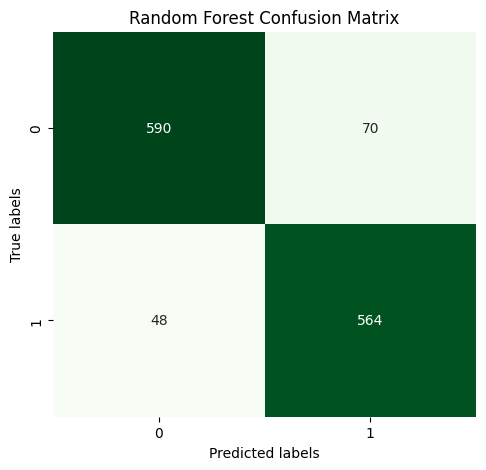

In [28]:
# confusion matrix for Random Forest
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)

# plotting confusion matrix for Random Forest
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Confusion Matrix')

We selected a Random Forest model due to its ability to handle complex datasets and mitigate overfitting compared to single Decision Trees. Random Forests aggregate predictions from multiple decision trees, providing robustness and improved generalization. This ensemble approach is particularly beneficial when dealing with high-dimensional data or when there are interactions between features that need to be captured.

Upon hyperparameter tuning via grid search, the Random Forest model achieved a classification accuracy of approximately 91%, which is higher than our Decision Tree model. The precision, recall, and F1-score for both classes indicate a balanced performance in identifying positive and negative cases. The Random Forest model offers a powerful and versatile solution for classifying buildings' energy consumption scores based on the provided metrics, showcasing its effectiveness in handling such classification tasks.

## Naive Bayes

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Naive Bayes classifier
naive_bayes_classifier = NB()

# Train the classifier on the training data
naive_bayes_classifier.fit(X_train, y_train)

# Make predictions on the test data
NB_y_pred = naive_bayes_classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, NB_y_pred)
print("Claasification Accuracy:", accuracy)

# classification report for NB
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, NB_y_pred))

Claasification Accuracy: 0.8254716981132075

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       660
           1       0.81      0.83      0.82       612

    accuracy                           0.83      1272
   macro avg       0.83      0.83      0.83      1272
weighted avg       0.83      0.83      0.83      1272



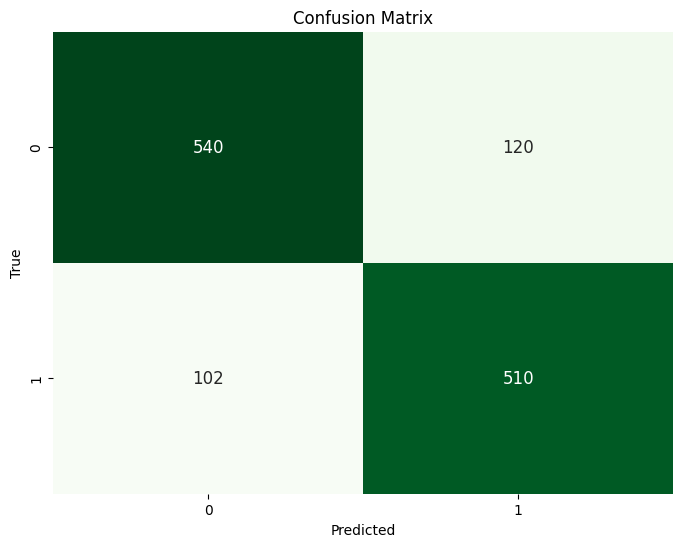

In [30]:
y_pred = naive_bayes_classifier.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', cbar=False, annot_kws={"size": 12})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

For the Naive Bayes model, we utilized it due to its simplicity, fast training speed, and effectiveness with high-dimensional data. Naive Bayes classifiers make strong independence assumptions between features, which can be advantageous in scenarios where the features are conditionally independent given the class label or when there's a large number of features relative to the number of samples.

Upon training the Naive Bayes classifier and evaluating it on the test data, we observed a classification accuracy of approximately 83%, which is extremely low compared to our other 2 models. The precision, recall, and F1-score for both classes indicate a reasonably balanced performance in identifying positive and negative cases, although slightly lower compared to other models. Despite its simplicity, the Naive Bayes model provides a competitive solution for classifying buildings' energy consumption scores based on the provided metrics, showcasing its effectiveness in certain contexts.

## QDA

In [31]:
# QDA Pipeline
QDA_pipeline = Pipeline([
    ('transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler()),
    ('QDA', QuadraticDiscriminantAnalysis())
])

# Define the hyperparameter grid for QDA
qda_param_grid = {
    'QDA__reg_param': [0.0, 0.1, 0.5, 1.0]
}

# Hyperparameter tuning
QDA_grid_search = GridSearchCV(QDA_pipeline, qda_param_grid, cv=5, scoring='accuracy')
QDA_grid_search.fit(X_train, y_train)
QDA_best_model = QDA_grid_search.best_estimator_

# prediction
QDA_y_pred = QDA_best_model.predict(X_test)

# Calculating Accuracy
QDA_accuracy = accuracy_score(y_test, QDA_y_pred)
print('Classification accuracy:', QDA_accuracy)

# classification report for QDA
print("\nQDA Classification Report:")
print(classification_report(y_test, QDA_y_pred))

Classification accuracy: 0.8514150943396226

QDA Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       660
           1       0.83      0.87      0.85       612

    accuracy                           0.85      1272
   macro avg       0.85      0.85      0.85      1272
weighted avg       0.85      0.85      0.85      1272



In [32]:
# Get the best hyperparameters
best_params = QDA_grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'QDA__reg_param': 1.0}


Text(0.5, 1.0, 'QDA Confusion Matrix')

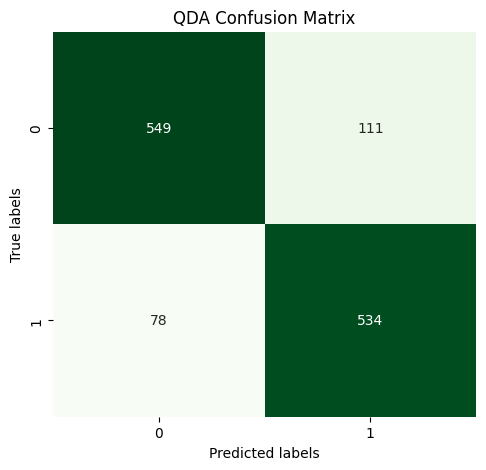

In [33]:
# confusion matrix for QDA
QDA_conf_matrix = confusion_matrix(y_test, QDA_y_pred)

# plotting confusion matrix for QDA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(QDA_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('QDA Confusion Matrix')


We employed Quadratic Discriminant Analysis (QDA) due to its ability to capture complex decision boundaries and handle non-linear relationships between features and the target variable. QDA is particularly suitable when the class distributions have different covariances or when the decision boundary is non-linear.

Upon hyperparameter tuning via grid search, the QDA model achieved a classification accuracy of approximately 85%. The precision, recall, and F1-score for both classes indicate a balanced performance in identifying positive and negative cases. The QDA model offers a competitive solution for classifying buildings' energy consumption scores based on the provided metrics, demonstrating its effectiveness in capturing complex relationships within the data.

## SVM

In [34]:
# SVM pipeline
svm_pipeline = Pipeline([
    ('transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler()),
    ('SVM', SVC(random_state=42))
])

# Define the hyperparameter grid
svm_param_grid = {
    'SVM__C': [0.1, 1, 10],
    'SVM__gamma': [0.1, 0.01],
    'SVM__kernel': ['linear', 'rbf']
}

# Hyperparameter tuning
SVM_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy')
SVM_grid_search.fit(X_train, y_train)
SVM_best_model = SVM_grid_search.best_estimator_

# prediction
SVM_y_pred = SVM_best_model.predict(X_test)

# Calculating Accuracy
SVM_accuracy = accuracy_score(y_test, SVM_y_pred)
print('Classification accuracy:', SVM_accuracy)

# classification report for SVM
print("\nSVM Classification Report:")
print(classification_report(y_test, SVM_y_pred))

Classification accuracy: 0.910377358490566

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       660
           1       0.90      0.91      0.91       612

    accuracy                           0.91      1272
   macro avg       0.91      0.91      0.91      1272
weighted avg       0.91      0.91      0.91      1272



In [35]:
# Get the best hyperparameters
best_params = SVM_grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'SVM__C': 1, 'SVM__gamma': 0.1, 'SVM__kernel': 'linear'}


Text(0.5, 1.0, 'SVM Confusion Matrix')

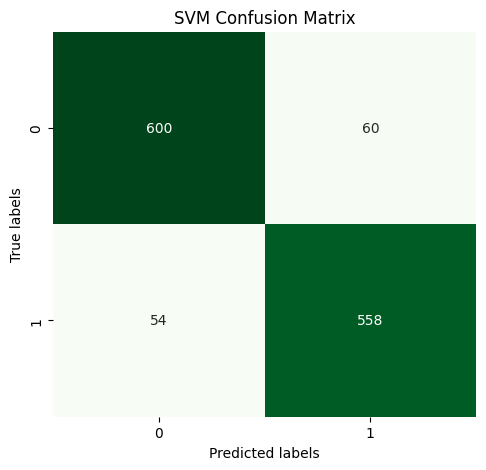

In [36]:
# confusion matrix for SVM
SVM_conf_matrix = confusion_matrix(y_test, SVM_y_pred)

# plotting confusion matrix for SVM
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(SVM_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVM Confusion Matrix')


We utilized Support Vector Machines (SVM) due to their versatility in handling various types of data and their effectiveness in capturing complex relationships between features. SVMs are capable of finding optimal decision boundaries by maximizing the margin between classes, making them suitable for classification tasks with non-linear decision boundaries.

Upon hyperparameter tuning via grid search, the SVM model achieved a classification accuracy of approximately 91%. The precision, recall, and F1-score for both classes indicate a balanced performance in identifying positive and negative cases. The SVM model offers a competitive solution for classifying buildings' energy consumption scores based on the provided metrics, showcasing its effectiveness in capturing complex patterns within the data.

### Logistic Regression

In [37]:
# pipeline
pipeline = Pipeline([
    ('transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler()),
    ('LR', LogisticRegression(random_state=42, max_iter=1000))
])


# hyperparameter tuning
param_grid = {'LR__C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# get the best model
best_model = grid_search.best_estimator_

# predict
y_pred = best_model.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Classification Accuracy:", accuracy)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Classification Accuracy: 0.9166666666666666

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       660
           1       0.90      0.92      0.91       612

    accuracy                           0.92      1272
   macro avg       0.92      0.92      0.92      1272
weighted avg       0.92      0.92      0.92      1272



In [38]:
# printing the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'LR__C': 1}


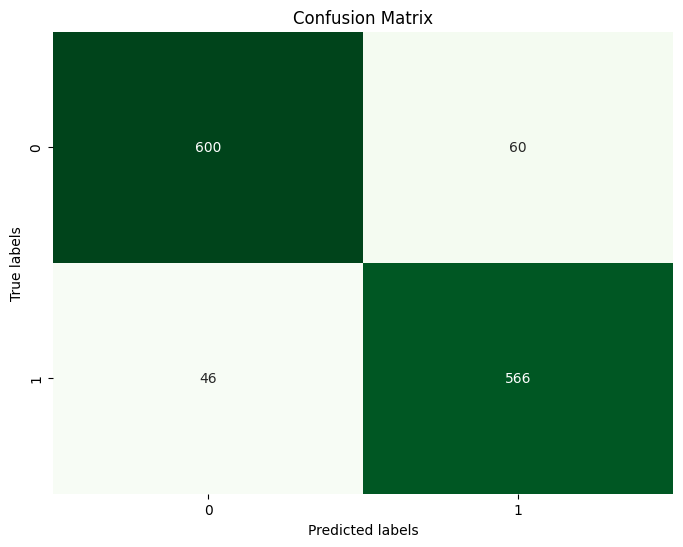

In [39]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

We chose this logistic regression model due to its ability to handle potentially skewed features through a pipeline that includes a PowerTransformer and a StandardScaler, thereby improving the model's performance. After hyperparameter tuning via grid search, the selected model achieved a high classification accuracy of approximately 92%. The precision, recall, and F1-score for both classes demonstrate a good balance in correctly identifying positive and negative cases. This model appears to effectively classify buildings' energy consumption scores based on the provided metrics, making it a suitable choice for the task at hand.

## LightGBM

In [41]:
# LightGBM pipeline
lgbm_pipeline = Pipeline([
    ('transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler()),
    ('LGBM', LGBMClassifier(random_state=42, verbosity=-1))
])

# parameter grid for LightGBM
lgbm_param_grid = {
    'LGBM__num_leaves': [20, 30, 40],  # max number of leaves in one tree
    'LGBM__max_depth': [5, 10],  # max tree depth for base learners, -1 means no limit
    'LGBM__learning_rate': [0.05, 0.1, 0.2]  # boosting learning rate
}

# hyperparameter tuning for LightGBM
lgbm_grid_search = GridSearchCV(lgbm_pipeline, lgbm_param_grid, cv=5, scoring='accuracy', verbose = False)
lgbm_grid_search.fit(X_train, y_train)
lgbm_best_model = lgbm_grid_search.best_estimator_

# predictions
lgbm_y_pred = lgbm_best_model.predict(X_test)

# calculating accuracy for LightGBM
lgbm_accuracy = accuracy_score(y_test, lgbm_y_pred)
print("LightGBM Classification Accuracy:", lgbm_accuracy)

# classification report for LightGBM
print("\nLightGBM Classification Report:")
print(classification_report(y_test, lgbm_y_pred))

LightGBM Classification Accuracy: 0.9166666666666666

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       660
           1       0.91      0.92      0.91       612

    accuracy                           0.92      1272
   macro avg       0.92      0.92      0.92      1272
weighted avg       0.92      0.92      0.92      1272



In [42]:
# Get the best hyperparameters
best_params = lgbm_grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'LGBM__learning_rate': 0.1, 'LGBM__max_depth': 5, 'LGBM__num_leaves': 20}


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

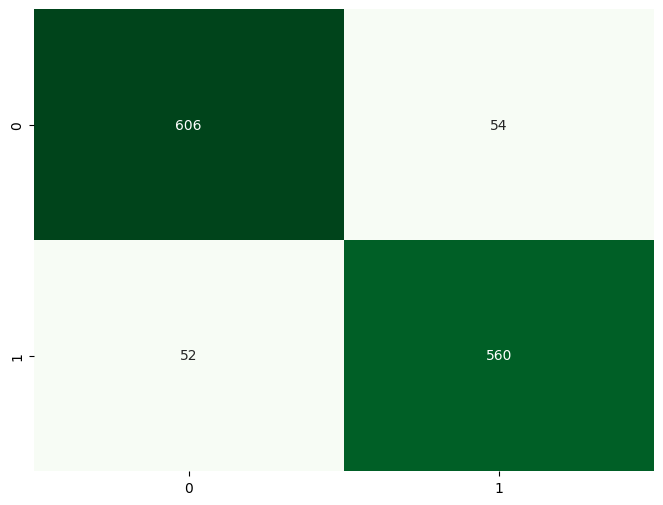

In [43]:
# confusion matrix for LightGBM
lgbm_conf_matrix = confusion_matrix(y_test, lgbm_y_pred)

# plotting confusion matrix for LightGBM
plt.figure(figsize=(8, 6))
sns.heatmap(lgbm_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel

We opted for the LightGBM model due to its efficiency in handling large datasets and its capability to provide fast training times while maintaining high predictive accuracy. LightGBM is specifically designed to work well with categorical features and can handle missing data effectively, making it suitable for various real-world datasets.

Following hyperparameter tuning via grid search, the LightGBM model achieved a classification accuracy of approximately 92%, which is higher than our Decision Tree and Random Forest models, and on par in predictive power with our Logistic Regression model. The precision, recall, and F1-score for both classes indicate a balanced performance in identifying positive and negative cases. Overall, the LightGBM model offers a competitive solution for classifying buildings' energy consumption scores based on the provided metrics, demonstrating its effectiveness and efficiency in handling such classification tasks.

## Feature Importance using our Logistic Regression Model

In [44]:
feature_names = df1.columns

index_mapping = {idx: feature_name for idx, feature_name in enumerate(feature_names)}

coefficients = best_model.named_steps['LR'].coef_[0]

for idx, coef in enumerate(coefficients):
    feature_name = index_mapping.get(idx, f'Feature {idx}')
    print(f"{feature_name}: {coef}")

SQFTC: 4.675830383664862
RFCOOL: -0.08571417571676015
GLSSPC: 0.09904696166983369
NFLOOR: 0.27694399364663586
FLCEILHT: 0.06400812796845469
ATTIC: 0.12094821868605644
YRCONC: -0.047639683277040844
FACIL: -0.017913506534359025
GOVOWN: -0.1445588819842141
OWNOPR: 0.07531793623867997
MONUSE: -0.06369648175503906
OPNMF: -0.025177874426919065
OPNWE: -0.13005432117313998
NWKER: 1.5937697817424146
WATR: -0.014514943677173063
EGYUSED: 0.0
ELUSED: 0.0
NGUSED: -0.27137257543236526
SOHT1: 0.0
FKHT2: -0.2351925659663107
PRHT2: -0.021518168517185347
COHT2: 0.0
SOHT2: -0.016376505250085636
NGCOOL: 0.0794650359053153
FKCOOL: 0.011841471883072644
PRCOOL: 0.01798565066874122
OTCOOL: -0.02433135603735048
ELWATR: 0.11127481467057808
NGWATR: 0.0477639628663598
FKWATR: -0.04784629605157078
PRWATR: 0.1934721092833258
WOWATR: 0.0
COWATR: 0.0
SOWATR: -0.02485715343545958
OTWATR: 0.1349439423115567
ELCOOK: -0.09045718082979257
NGCOOK: -0.3614801231754906
FKCOOK: 0.1436691617154252
PRCOOK: 0.1306659609390441
CO

Some interesting observations from the output above:
- Higher SQFT (SQFTC) and higher number of workers (NWKER) contribute the most to high energy consumption.
- Hotter areas use much less energy (PPUBCLIM_5). Likely because heating costs in the United States are much higher than cooling costs.
- Number of heating days (HDD65) is also a large contributor to increasing energy consumption due to heating being more expensive.
- Narrow rectangles (BLDSHP_3) are the least energy efficient building shape.
- Vacant buildings (PBA_1) contribute to higher energy consumption.
- Food service buildings (PBA_15) contribute to higher energy consumption.

In [45]:
# Explain the predictions using SHAP
explainer = shap.Explainer(best_model.named_steps['LR'], X_train)
shap_values = explainer(X_test)

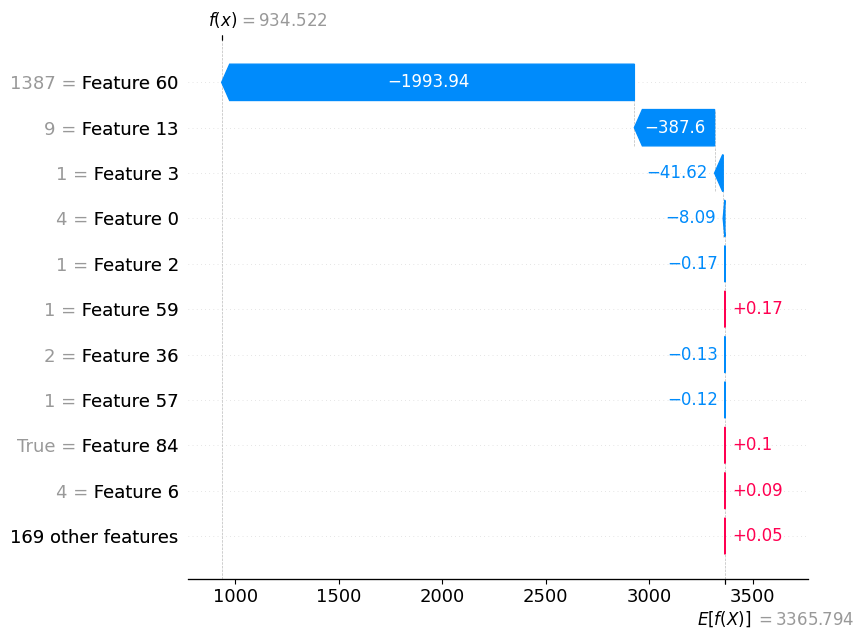

In [46]:
# Generate the waterfall plot for the first instance in X_test
instance_index = 0  # Change this index to visualize a different instance
shap.waterfall_plot(shap.Explanation(values=shap_values[instance_index], base_values=explainer.expected_value, data=X_test), max_display=11)

In [47]:
column_names = df1.columns.tolist()
print(column_names[68], column_names[21], column_names[9], column_names[2], column_names[0],
      column_names[13], column_names[7], column_names[8], column_names[44], column_names[6])

PBA_16 COHT2 OWNOPR GLSSPC SQFTC NWKER FACIL GOVOWN HWMANU YRCONC


## Feature importance ranking according to the plot above
1. HDD65: Heating degree days
2. NWKER: Number of employees
3. NFLOOR: Number of floors
4. SQFTC: Square footage category
5. PBA: Principal building category
6. PBAPLUS: More specific building activity
7. BLDSHP: Building shape
8. GLSSPC: Percent exterior glass
9. NGCOOK: Natural gas used for cooking
10. RFTILT: Roof tilt

# Conclusion

The choice of the model depends on various factors such as the dataset's characteristics, interpretability requirements, computational resources, and the desired balance between accuracy and model complexity. In our project, models like Random Forest, LightGBM, and SVM all exhibited strong overall performance and may be preferred when high accuracy and capturing complex relationships is more important, while simpler models like Logistic Regression or Naive Bayes can provide interpretable results with faster training times. The final model we ended up choosing for generating predictions and making interpretations from is the Logistic Regression model, which matched the accuracy of our more complex models. Logistic Regression and LightGBM offer the same accuracy, but Logistic Regression's linear nature allows for clearer interpretation of coefficients, aiding in understanding predictor impacts.

The Logistic Regression analysis reveals insightful observations regarding building characteristics and their impact on energy consumption. Notably, variables such as square footage and the number of workers exhibit significant coefficients, indicating their substantial contributions to total energy usage. It is unsurprising that larger square footage correlates with higher energy consumption, while an increase in the number of workers also escalates energy usage, likely due to heightened operational activities.

Moreover, the activity category with the highest energy consumption is food service buildings, attributable to the resource-intensive nature of restaurant operations, including cooking, lighting, and refrigeration demands.

Interestingly, there are some design elements such as building shape which have an effect on total energy consumption. Narrow rectangle shaped buildings are the least energy efficient. Uncomplicated dome structures retain the most heat while cubes have the smallest surface area to floor area ratio so these types are the most energy efficient (Building Science Corporation, 2012). Narrow rectangles do not have either of these characteristics which could be the reason behind its inefficiency.

Vacant buildings, especially in colder climates, pose significant energy challenges due to the need for heating, ventilation, and air conditioning systems to compensate for heat loss (Carleton University, 2022). This is also supported in our model output as a building being vacant contributes to high energy consumption.

We recognize that total energy consumption is not a perfect variable for explaining sustainability considering there are different types of energy being consumed. However, we believe this model is a good starting point for understanding the sustainability implications of commercial building characteristics. Understanding the relationship between building design, energy consumption, and sustainability is crucial for architects, engineers, and policymakers striving to promote energy-efficient and environmentally friendly building design and management practices.

### References

Building Science Corporation. (2012). BSI-061: Function follows form—building shape and energy. Building Science Corporation. Retrieved from https://buildingscience.com/documents/insights/bsi-061-function-form-building-shape-and-energy

Carleton University. (2022). Empty buildings consume energy. Carleton University Newsroom. Retrieved from https://newsroom.carleton.ca/story/empty-buildings-consume-energy/#:~:text=Our%20research%20found%20that%20empty,of%20people%20in%20these%20buildings.

Dataset: U.S. Energy Information Administration. (2018). 2018 Commercial Buildings Energy Consumption Survey (CBECS) Microdata. Retrieved from https://www.eia.gov/consumption/commercial/data/2018/index.php?view=microdata